In [1]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
with open('/content/gdrive/My Drive/greenatom_data/negatives_data_train.pkl', 'rb') as f:
   negatives_data_train = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/negatives_targets_train.pkl', 'rb') as f:
   negatives_targets_train = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/positives_data_train.pkl', 'rb') as f:
   positives_data_train = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/positives_targets_train.pkl', 'rb') as f:
   positives_targets_train = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/negatives_data_test.pkl', 'rb') as f:
   negatives_data_test = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/negatives_targets_test.pkl', 'rb') as f:
   negatives_targets_test = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/positives_data_test.pkl', 'rb') as f:
   positives_data_test = pickle.load(f)
with open('/content/gdrive/My Drive/greenatom_data/positives_targets_test.pkl', 'rb') as f:
   positives_targets_test = pickle.load(f)

In [4]:
data_train = positives_data_train + negatives_data_train
targets_train = positives_targets_train + negatives_targets_train
data_test = positives_data_test + negatives_data_test
targets_test = positives_targets_test + negatives_targets_test
data = data_train + data_test
y_train = list(map(lambda x:int(x), targets_train))
y_valid = list(map(lambda x:int(x), targets_test))

In [5]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [6]:
#count number of occurences of each word
counts = Counter()
for review in data:
    counts.update(tokenize(review))

In [7]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 99453
num_words after: 62136


In [8]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [104]:
#count words in sentences
c = []
for review in data:
  c.append(len(tokenize(review)))

print(min(c))
print(max(c))
sum(c)/len(c)

6
2786


271.60274

In [106]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


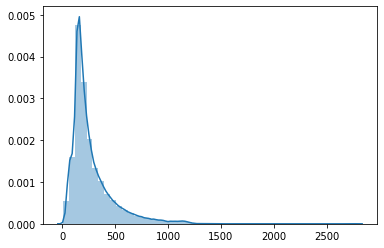

In [115]:
sns.distplot(c);

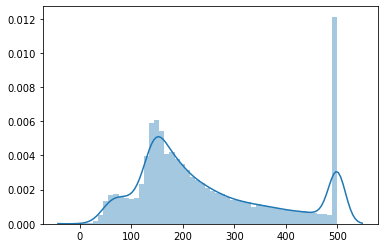

In [114]:
c_ = list(map(lambda x: 500 if x > 500 else x, c))
sns.distplot(c_);

Reviews are too long, hence LSTM is bad. Will try anyway...

In [83]:
def encode_sentence(text, vocab2index=vocab2index, N=100):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [84]:
%%time
X_train = list(map(encode_sentence, data_train))
X_valid = list(map(encode_sentence, data_test))

CPU times: user 54.6 s, sys: 153 ms, total: 54.8 s
Wall time: 54.7 s


In [85]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]


In [86]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [87]:
batch_size = 128
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
for x in train_dl:
  print(x)
  break 

[tensor([[  12, 5901,   64,  ...,    0,    0,    0],
        [1640,   19, 4446,  ..., 1379,   36,  437],
        [ 292,    4,    5,  ...,    0,    0,    0],
        ...,
        [1806, 1807,  516,  ...,  193, 6532,   16],
        [ 292, 1438,  884,  ...,  105, 1584, 1228],
        [  62,  416, 3261,  ...,    0,    0,    0]], dtype=torch.int32), tensor([10,  1,  2,  ...,  4,  9,  9]), tensor([ 56, 300,  94,  ..., 300, 300, 136])]


In [88]:
def train_model_regr(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            x = x.to(device)
            y = y.float()
            y = y.to(device)
            l = l.to(device)
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.mse_loss(y_pred, y.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss = validation_metrics_regr(model, val_dl)
        if i % 5 == 1:
            print("train mse %.3f val rmse %.3f" % (sum_loss/total, val_loss))

def validation_metrics_regr (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        x = x.to(device)
        y = y.float()
        y = y.to(device)
        l = l.to(device)
        y_hat = model(x, l)
        loss = np.sqrt(F.mse_loss(y_hat, y.unsqueeze(-1)).item())
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total

In [89]:
class LSTM_regr(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [94]:
model =  LSTM_regr(vocab_size, 50, 50)
model = model.to(device)

In [95]:
%%time
train_model_regr(model, epochs=30, lr=0.01)

train mse 11.784 val rmse 3.477
train mse 3.464 val rmse 2.839
train mse 1.819 val rmse 2.902
train mse 1.289 val rmse 2.937
train mse 0.983 val rmse 2.910
train mse 0.815 val rmse 2.963
CPU times: user 56.1 s, sys: 2.17 s, total: 58.3 s
Wall time: 58.4 s
